In [1]:
from simformer.simformer import *
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.patches as patches
import seaborn as sns

import numpy as np
import torch
import os

%matplotlib inline

# Load data

In [2]:
# --- Load in training data ---
path_training = os.getcwd() + '/simformer/data/chempy_TNG_train_data.npz'
training_data = np.load(path_training, mmap_mode='r')

elements = training_data['elements']
train_x = training_data['params']
train_y = training_data['abundances']


# ---  Load in the validation data ---
path_test = os.getcwd() + '/simformer/data/chempy_TNG_val_data.npz'
val_data = np.load(path_test, mmap_mode='r')

val_x = val_data['params']
val_y = val_data['abundances']


# --- Clean the data ---
# Chempy sometimes returns zeros or infinite values, which need to removed
def clean_data(x, y):
    # Remove all zeros from the training data
    index = np.where((y == 0).all(axis=1))[0]
    x = np.delete(x, index, axis=0)
    y = np.delete(y, index, axis=0)

    # Remove all infinite values from the training data
    index = np.where(np.isfinite(y).all(axis=1))[0]
    x = x[index]
    y = y[index]

    # Remove H from Elements
    y = np.delete(y, 2, 1)

    return x, y


train_x, train_y = clean_data(train_x, train_y)
val_x, val_y     = clean_data(val_x, val_y)

# convert to torch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
val_x = torch.tensor(val_x, dtype=torch.float32)
val_y = torch.tensor(val_y, dtype=torch.float32)

train_data = torch.cat((train_x, train_y), 1)
val_data = torch.cat((val_x, val_y), 1)

## Define Simformer

In [3]:
# Define the simformer

# Time steps for the diffusion process
T = 50
t = torch.linspace(0, 1, T)

simformer = Simformer(T, train_data.shape)

/export/home/bguenes/anaconda3/envs/simformer_torch/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [4]:
train_data.shape

torch.Size([498314, 14])

In [5]:
val_data.shape

torch.Size([49824, 14])

## Train diffusion model

In [6]:
simformer.train(train_data, condition_mask_data=torch.ones_like(train_data), val_data=val_data, condition_mask_val=torch.ones_like(val_data))

Epoch  0/10 -- Training Loss: 35640296.887 -- Validation Loss: 2587436.250


Epoch  1/10 -- Training Loss: 26171973.846 -- Validation Loss: 2554903.250


Epoch  2/10 -- Training Loss: 25112964.708 -- Validation Loss: 2513751.250


Epoch  3/10 -- Training Loss: 24407407.363 -- Validation Loss: 2412827.500


Epoch  4/10 -- Training Loss: 24203878.342 -- Validation Loss: 2500286.750


Epoch  5/10 -- Training Loss: 24022803.944 -- Validation Loss: 2229940.500


Epoch  6/10 -- Training Loss: 23782683.397 -- Validation Loss: 2470474.500


Epoch  7/10 -- Training Loss: 23718706.211 -- Validation Loss: 2373105.750


Epoch  8/10 -- Training Loss: 23577540.797 -- Validation Loss: 2295266.500


Epoch  9/10 -- Training Loss: 23410372.272 -- Validation Loss: 2313083.000


In [4]:
simformer.train_loss

AttributeError: 'Simformer' object has no attribute 'train_loss'

In [8]:
val_data.shape

torch.Size([49824, 14])

In [10]:
torch.save(simformer.state_dict(), "simformer/models/simformer_t100.pt")

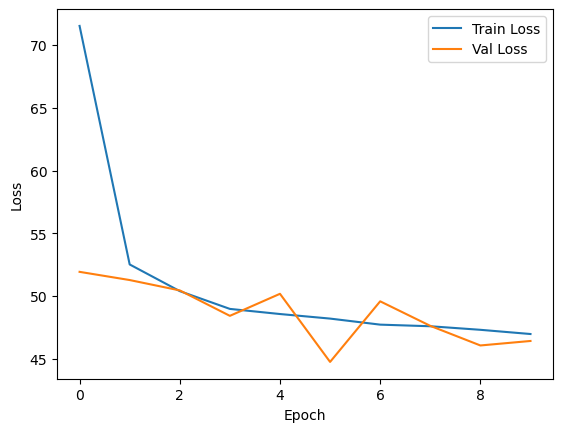

In [11]:
epoch = np.arange(0, len(simformer.train_loss))

plt.plot(epoch, np.array(simformer.train_loss)/train_data.shape[0], label='Train Loss')
plt.plot(epoch, np.array(simformer.val_loss)/val_data.shape[0], label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [6]:
simformer.load_state_dict(torch.load("simformer/models/simformer_t100.pt", weights_only=False))

<All keys matched successfully>

## Data Generation

In [7]:
# Create random datapoints to denoise
sample_data_t1 = torch.randn(10000, train_data.shape[1])*2

In [8]:
sample_data_t0 = simformer.sample(sample_data_t1, condition_mask=torch.ones_like(sample_data_t1))

100%|██████████| 50/50 [03:00<00:00,  3.60s/it]


In [11]:
sample_data_t0.mean(axis=0)

tensor([-2.3065, -2.9131, -0.3185,  0.5626,  0.5012,  4.5527,  0.0793, -0.2520,
         0.2596,  0.3056,  0.1051,  0.5832,  0.4186,  0.2867])

In [12]:
sample_data_t0.std(axis=0)

tensor([0.0127, 0.0156, 0.0098, 0.0067, 0.0066, 0.3902, 0.0098, 0.0440, 0.0422,
        0.0130, 0.0109, 0.0119, 0.0142, 0.0134])

In [13]:
priors = [-2.3, -2.89, -0.3, 0.55, 0.5]
sigma = [0.3, 0.3, 0.3, 0.1, 0.1]

In [15]:
denoising_data = simformer.x_t.detach().numpy()
score_t = simformer.score_t.detach().numpy()
dx = simformer.dx_t.detach().numpy()
t = simformer.t.detach().numpy()

In [90]:
np.repeat(scaling_factor[:,np.newaxis], 2, axis=1)

array([[-0.01      , -0.01      ],
       [-0.01140404, -0.01140404],
       [-0.01300522, -0.01300522],
       [-0.0148312 , -0.0148312 ],
       [-0.01691356, -0.01691356],
       [-0.0192883 , -0.0192883 ],
       [-0.02199645, -0.02199645],
       [-0.02508484, -0.02508484],
       [-0.02860686, -0.02860686],
       [-0.03262338, -0.03262338],
       [-0.03720384, -0.03720384],
       [-0.04242741, -0.04242741],
       [-0.04838439, -0.04838439],
       [-0.05517776, -0.05517776],
       [-0.06292494, -0.06292494],
       [-0.07175987, -0.07175987],
       [-0.08183525, -0.08183525],
       [-0.09332524, -0.09332524],
       [-0.1064285 , -0.1064285 ],
       [-0.12137151, -0.12137151],
       [-0.13841255, -0.13841255],
       [-0.15784626, -0.15784626],
       [-0.18000852, -0.18000852],
       [-0.20528243, -0.20528243],
       [-0.23410498, -0.23410498],
       [-0.26697424, -0.26697424],
       [-0.30445853, -0.30445853],
       [-0.34720585, -0.34720585],
       [-0.39595497,

In [92]:
a = simformer.score_t[0,:-1,:2].detach().numpy()*np.repeat(scaling_factor[:,np.newaxis], 2, axis=1)

In [20]:
print(denoising_data[0,0,:2])
print(denoising_data[0,1,:2])

print(-dx[0,0,:2])

[1.5326858  0.41689107]
[-2.1881614 -3.2723763]
[-3.7208471 -3.6892674]


In [95]:
denoising_data[0,0,:2]-a[0,:2]

array([-6.586781 ,  0.8615877], dtype=float32)

In [63]:
scaling_factor = -0.5*simformer.sigma**(2*t)*(1/T)

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 500  
plt.ioff()
fig, ax = plt.subplots()

def animate(i):
    plt.clf()
    plt.xlim(-5,5)
    plt.ylim(-5,5)
    plt.xlabel(r'$\alpha_{IMF}$')
    plt.ylabel(r'$\log_{10}N$')
    plt.title(f'Denoising Timestep: {i}')

    sns.set_style("white")
    sns.kdeplot(x=denoising_data[:,i,0], y=denoising_data[:,i,1], cmap='Blues', fill=True, levels=100, bw_adjust=0.6)
    plt.tight_layout()

ani2 = matplotlib.animation.FuncAnimation(fig, animate, frames=25) 

writer = matplotlib.animation.PillowWriter(fps=5,
                                bitrate=-1)
ani2.save('plots/test_big.gif', writer=writer)

"\nplt.scatter(denoising_data[:,0,0], denoising_data[:,0,1], s=0.5)\nfor i in range(len(denoising_data)):\n    plt.arrow(denoising_data[i,0,0], denoising_data[i,0,1], score_t[i,0,0]*scaling_factor[0], score_t[i,0,1]*scaling_factor[0], color='b', head_width=0.03)\n\nplt.show()"

In [38]:
denoising_data[0,1,:2]

array([-2.1881614, -3.2723763], dtype=float32)

In [41]:
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 500  
plt.ioff()
fig, ax = plt.subplots()

def animate(i):
    plt.clf()
    plt.xlim(-5,5)
    plt.ylim(-5,5)
    plt.xlabel(r'$\alpha_{IMF}$')
    plt.ylabel(r'$\log_{10}N$')
    plt.title(f'Denoising Timestep: {i}')

    plt.quiver(denoising_data[0,:i+1,0], denoising_data[0,:i+1,1], -dx[0,:i+1,0], -dx[0,:i+1,1], scale=1, scale_units='xy', width=0.003)
    plt.scatter(denoising_data[0,:i+1,0], denoising_data[0,:i+1,1], s=20, marker='x', color='black')
    #plt.hist2d(denoising_data[:,i,0], denoising_data[:,i,1])
    plt.tight_layout()

    #plt.scatter(denoising_data[:,i,0], denoising_data[:,i,1], s=0.5)
    #for j in range(len(denoising_data)):
    #    plt.arrow(denoising_data[j,i,0], denoising_data[j,i,1], score_t[j,i,0]*scaling_factor[i], score_t[j,i,1]*scaling_factor[i], color='black', head_width=0.05, alpha=0.6)

ani2 = matplotlib.animation.FuncAnimation(fig, animate, frames=25) 

writer = matplotlib.animation.PillowWriter(fps=5,
                                bitrate=-1)
ani2.save('plots/test_quiver.gif', writer=writer)

In [34]:
dx[0,0,0]

3.7208471